In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import the necessary libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

 # Read the DataFrames from CSV files

In [3]:
reddit_data = pd.read_csv('/content/drive/MyDrive/Sem VI/ML - OE/Twitter&Reddit/Reddit_Data.csv')
twitter_data = pd.read_csv('/content/drive/MyDrive/Sem VI/ML - OE/Twitter&Reddit/Twitter_Data.csv')

# DataFrames Information

In [4]:
reddit_data

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1
...,...,...
37244,jesus,0
37245,kya bhai pure saal chutiya banaya modi aur jab...,1
37246,downvote karna tha par upvote hogaya,0
37247,haha nice,1


In [5]:
twitter_data

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [6]:
reddit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


In [7]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [8]:
#renaming the columns
twitter_data.columns=['messages','labels']
reddit_data.columns=['messages','labels']

In [9]:
twitter_data.head()

,messages,labels
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [10]:
reddit_data.head()

,messages,labels
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


# Merge DataFrames

In [11]:
data = pd.concat([twitter_data, reddit_data], ignore_index = True)

In [12]:
data

,messages,labels
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
200224,jesus,0.0
200225,kya bhai pure saal chutiya banaya modi aur jab...,1.0
200226,downvote karna tha par upvote hogaya,0.0
200227,haha nice,1.0


In [13]:
data.tail()

,messages,labels
200224,jesus,0.0
200225,kya bhai pure saal chutiya banaya modi aur jab...,1.0
200226,downvote karna tha par upvote hogaya,0.0
200227,haha nice,1.0
200228,facebook itself now working bjp’ cell,0.0


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200229 entries, 0 to 200228
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   messages  200125 non-null  object 
 1   labels    200222 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.1+ MB


 # Handling Missing Values

In [15]:
data.isnull().sum()

messages    104
labels        7
dtype: int64

In [16]:
data = data.dropna()

In [17]:
data.head()

,messages,labels
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [18]:
data.tail()

,messages,labels
200224,jesus,0.0
200225,kya bhai pure saal chutiya banaya modi aur jab...,1.0
200226,downvote karna tha par upvote hogaya,0.0
200227,haha nice,1.0
200228,facebook itself now working bjp’ cell,0.0


# Data Preprocessing

In [19]:
#Libraries of NLTK
import re,string,nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer,WordNetLemmatizer

In [20]:
#cleaning the data from unnecessary data

#replacing url with string URL
def replace_url(text):
    return re.sub('https?:\/\/\S*|www\.\S+','URL',text)

#removing html
def remove_html(text):
    return re.sub('<.*?>','',text)

#replacing mentions with string user
def replace_mentions(text):
    return re.sub('@\S*','user',text,flags=re.IGNORECASE)

#replacing numbers with string number
def replace_num(text):
    return re.sub('^[+-]*?\d{1,3}[- ]*?\d{1,10}|\d{10}','NUMBER',text)

#replacing <3 with sring heart
def replace_heart(text):
    return re.sub('<3','HEART', text)

#removing alphanumeric characters eg-XYZ123ABC
def remove_alphanumeric(text):
    return re.sub('\w*\d+\w*','',text)

#removing all english stopwords
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
    return text

#removing punctuations
def remove_punctuations(text):
    text=''.join([word for word in text if word not in string.punctuation])
    return text

#reducing words to thier root form
def lemmatization(text):
    lm= WordNetLemmatizer()
    text = ' '.join([lm.lemmatize(word, pos='v') for word in text.split()])
    return text

In [21]:
def clean_text(text):
    text=str(text).lower()
    text = replace_url(text)
    text = remove_html(text)
    text = replace_mentions(text)
    text = replace_num(text)
    text = replace_heart(text)
    text = remove_alphanumeric(text)
    text = remove_stopwords(text)
    text=remove_punctuations(text)
    #text=stemming(text)
    text=lemmatization(text)
    return text

In [22]:
import nltk
from nltk.corpus import stopwords

# Assuming you've already downloaded the NLTK stopwords
nltk.download('stopwords')

# Define your clean_text function
def clean_text(text):
    # Your text cleaning operations here
    return text

# Apply clean_text function to the 'messages' column and store the result in 'messages1'
data['messages1'] = data['messages'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-22-d5ecd936c38e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['messages1'] = data['messages'].apply(clean_text)


In [23]:
data['messages1']

0         when modi promised “minimum government maximum...
1         talk all the nonsense and continue all the dra...
2         what did just say vote for modi  welcome bjp t...
3         asking his supporters prefix chowkidar their n...
4         answer who among these the most powerful world...
                                ...                        
200224                                                jesus
200225    kya bhai pure saal chutiya banaya modi aur jab...
200226                downvote karna tha par upvote hogaya 
200227                                           haha nice 
200228               facebook itself now working bjp’ cell 
Name: messages1, Length: 200118, dtype: object

# Sentiment Analysis

In [24]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [25]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment_scores(text):
    # Get sentiment scores using VADER
    scores = sid.polarity_scores(text)
    # Extract compound score, which represents overall sentiment
    compound_score = scores['compound']
    # Return compound score
    return compound_score

# Apply sentiment analysis to the cleaned text data
data['sentiment_score'] = data['messages1'].apply(get_sentiment_scores)


<ipython-input-25-28a27091f096>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment_score'] = data['messages1'].apply(get_sentiment_scores)


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200118 entries, 0 to 200228
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   messages         200118 non-null  object 
 1   labels           200118 non-null  float64
 2   messages1        200118 non-null  object 
 3   sentiment_score  200118 non-null  float64
dtypes: float64(2), object(2)
memory usage: 7.6+ MB


In [27]:
data.drop('messages', axis=1, inplace=True)

<ipython-input-27-27544148e1fc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('messages', axis=1, inplace=True)


In [28]:
data.head()

,labels,messages1,sentiment_score
0,-1.0,when modi promised “minimum government maximum...,0.5267
1,0.0,talk all the nonsense and continue all the dra...,-0.4019
2,1.0,what did just say vote for modi welcome bjp t...,0.7096
3,1.0,asking his supporters prefix chowkidar their n...,-0.0713
4,1.0,answer who among these the most powerful world...,0.4754


# EDA & Data Visualisation

<Axes: xlabel='labels'>

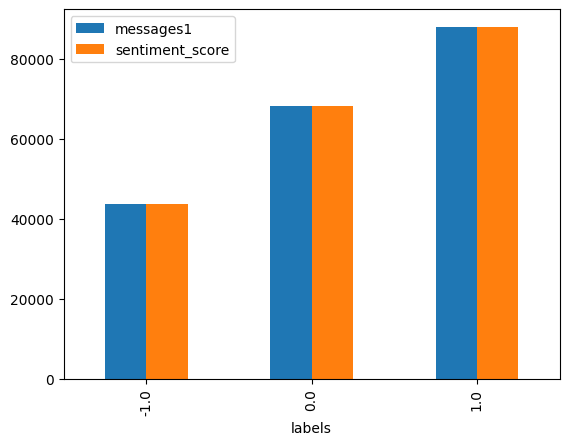

In [29]:
# The distribution of sentiments
data.groupby('labels').count().plot(kind='bar')

In [30]:
data['label'] = data['labels'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})

<ipython-input-30-95b0dc3750cd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = data['labels'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})


<ipython-input-31-8e689c2e3494>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['length'] = data.messages1.str.split().apply(len)


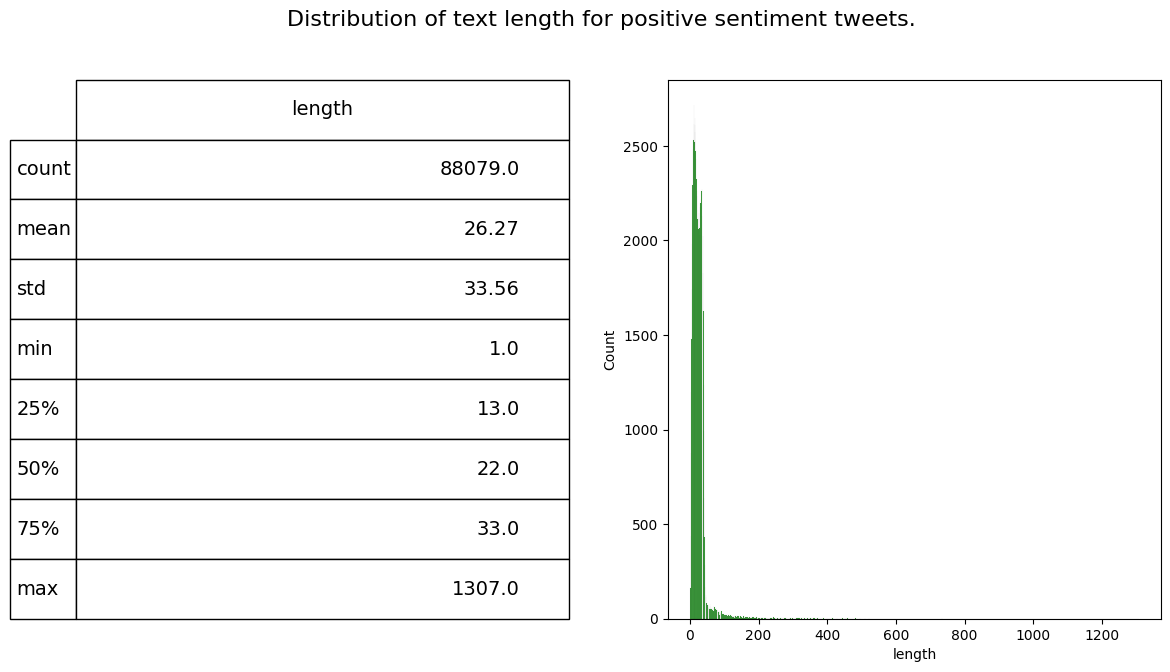

In [31]:
#Plotting the distribution of text length for positive sentiment Data
fig = plt.figure(figsize=(14,7))
data['length'] = data.messages1.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(data[data['label']=='Positive']['length'], ax=ax1,color='green')
describe = data.length[data.label=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

<ipython-input-32-385563b7302c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['length'] = data.messages1.str.split().apply(len)


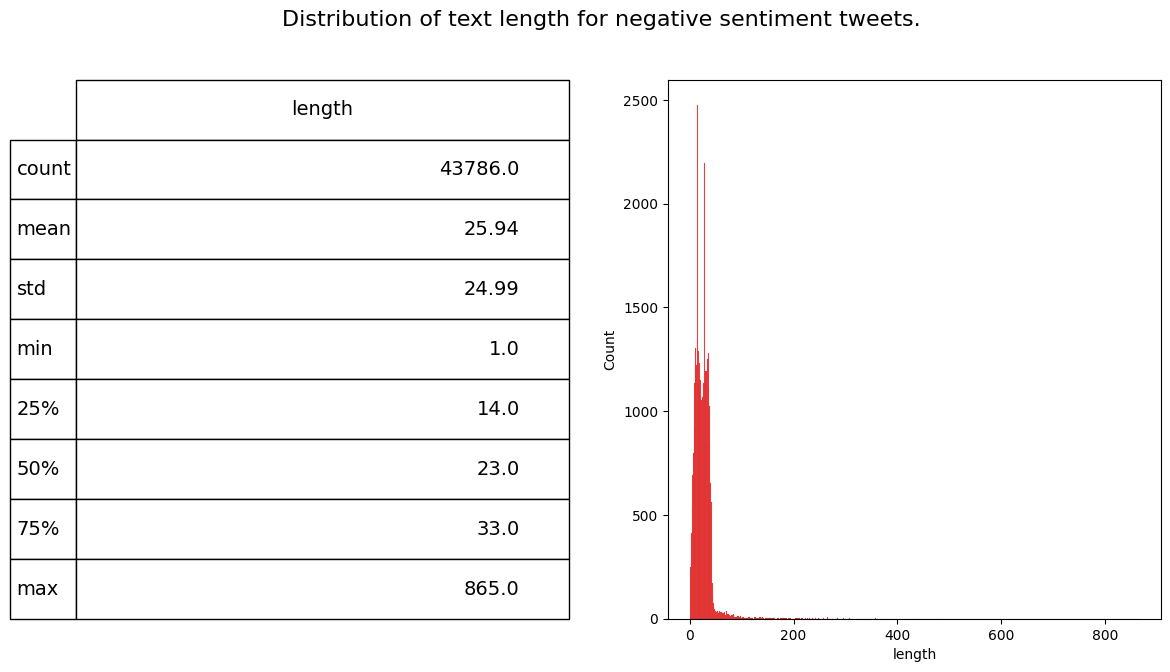

In [32]:
#Plotting the distribution of text length for Negative sentiment Data
fig = plt.figure(figsize=(14,7))
data['length'] = data.messages1.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(data[data['label']=='Negative']['length'], ax=ax1,color='red')
describe = data.length[data.label=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for negative sentiment tweets.', fontsize=16)

plt.show()

<ipython-input-33-95943ceffadd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['length'] = data.messages1.str.split().apply(len)


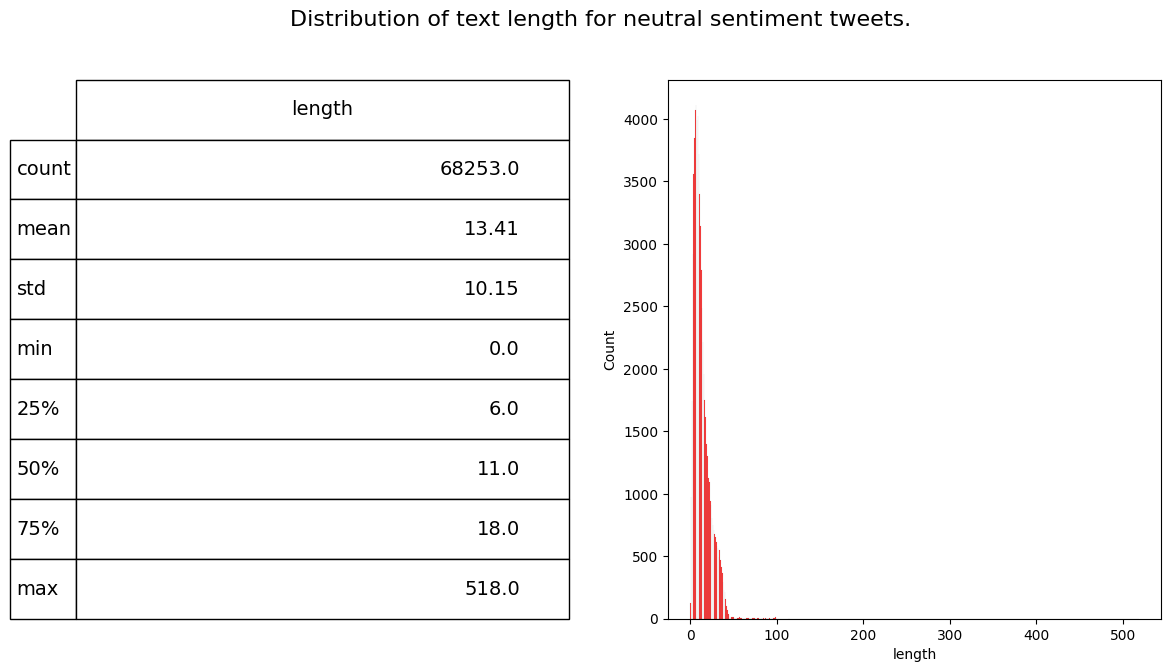

In [33]:
#Plotting the distribution of text length for Neutral sentiment Data
fig = plt.figure(figsize=(14,7))
data['length'] = data.messages1.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(data[data['label']=='Neutral']['length'], ax=ax1,color='red')
describe = data.length[data.label=='Neutral'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for neutral sentiment tweets.', fontsize=16)

plt.show()

In [34]:
import plotly.express as px
fig = px.pie(data, names='label', title ='Pie chart of different sentiments of data')
fig.show()

In [35]:
# data.drop(['length'], axis=1, inplace=True)
# data.head

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200118 entries, 0 to 200228
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   labels           200118 non-null  float64
 1   messages1        200118 non-null  object 
 2   sentiment_score  200118 non-null  float64
 3   label            200118 non-null  object 
 4   length           200118 non-null  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 9.2+ MB


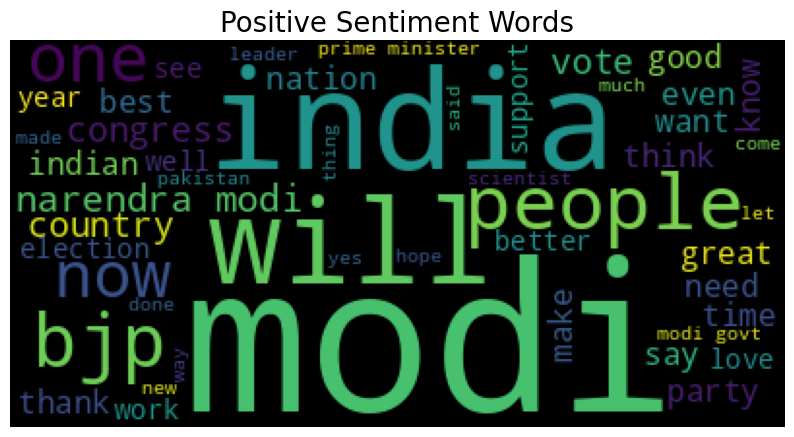

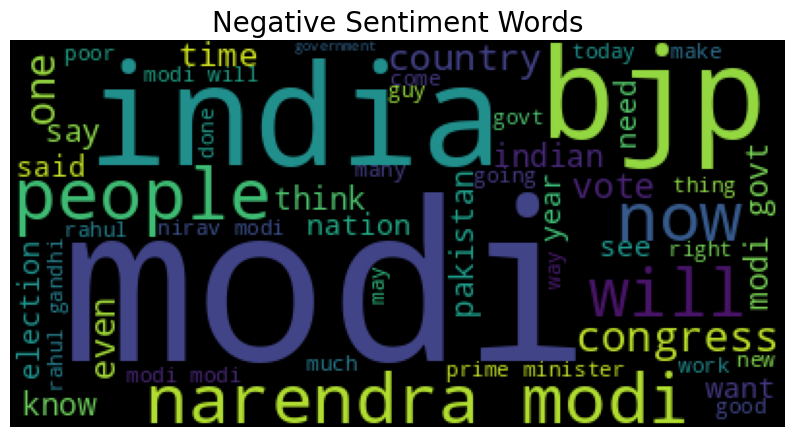

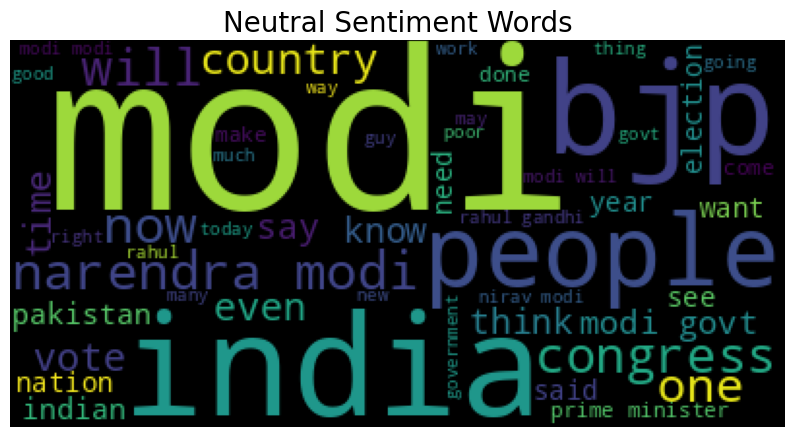

In [37]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
def wordcount_gen(df, category, sentiment_column='sentiment_score'):
              """
              Generating Word Cloud

              Inputs:
                - df: DataFrame containing the data
                - category: Positive/Negative/Neutral
                - sentiment_column (optional): Name of the column containing sentiment score (default: 'sentiment_score')
              """

              # Filter data based on sentiment
              filtered_data = df[df[sentiment_column] > 0.5] if category == 'Positive' else df[df[sentiment_column] <= 0.5]

              # Combine all messages from the filtered data
              combined_tweets = " ".join(filtered_data['messages1'])

              # Initialize wordcloud object
              wc = WordCloud(background_color='black',
                              max_words=50,
                              stopwords=STOPWORDS)

              # Generate and plot wordcloud
              plt.figure(figsize=(10, 10))
              plt.imshow(wc.generate(combined_tweets))
              plt.title('{} Sentiment Words'.format(category), fontsize=20)
              plt.axis('off')
              plt.show()
#Positive tweet words
wordcount_gen(data, 'Positive')

# Negative tweet words
wordcount_gen(data, 'Negative')

# Neutral tweet words (assuming sentiment_column < 0.5 is neutral)
wordcount_gen(data, 'Neutral')



In [38]:
# data.drop(['label'], axis=1, inplace=True)
# data.head()

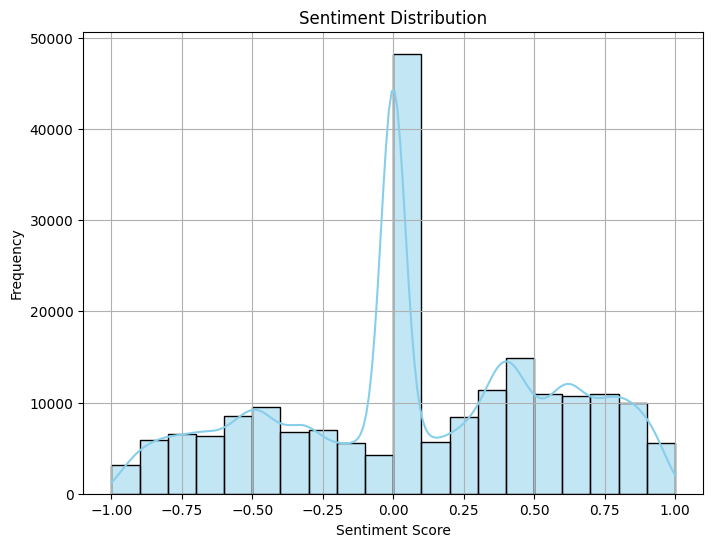

In [39]:
# Visualize sentiment distribution using a histogram
plt.figure(figsize=(8, 6))
sns.histplot(data['sentiment_score'], bins=20, kde=True, color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


<ipython-input-40-f76c39074626>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




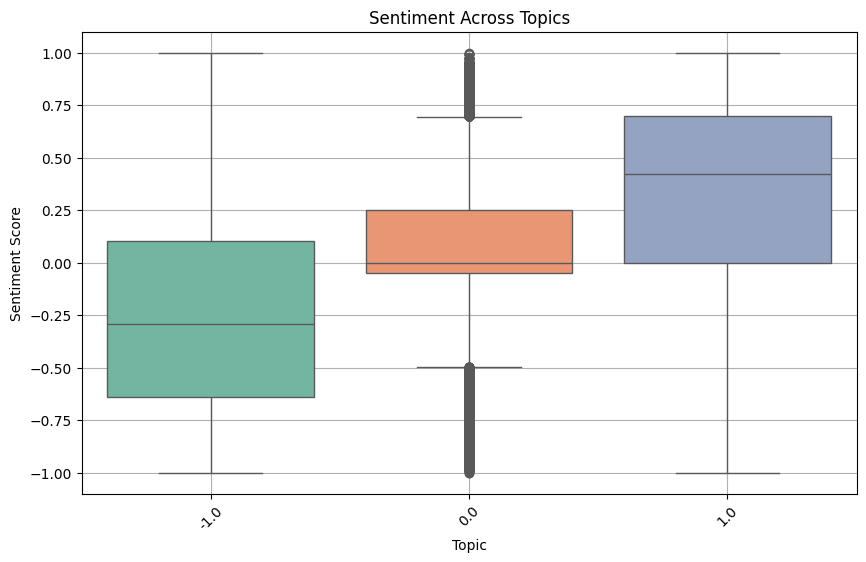

In [40]:
# Compare sentiment across labels
plt.figure(figsize=(10, 6))
sns.boxplot(x='labels', y='sentiment_score', data=data, palette='Set2')
plt.title('Sentiment Across Topics')
plt.xlabel('Topic')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

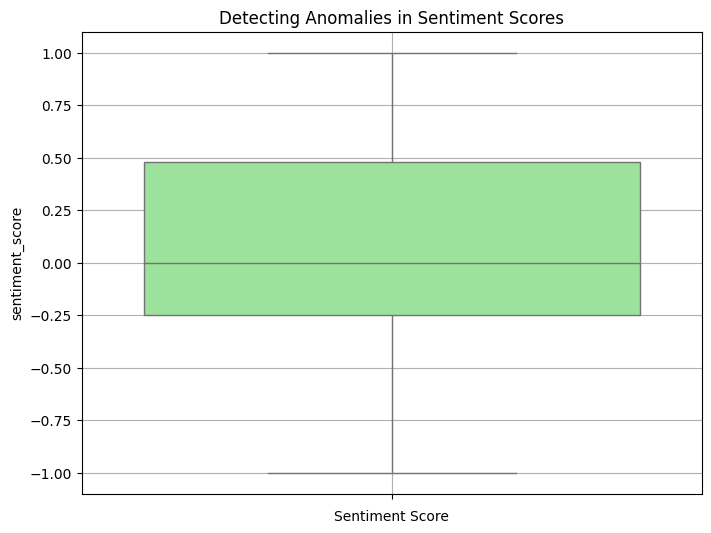

In [41]:
# Detect anomalies or outliers in sentiment scores
plt.figure(figsize=(8, 6))
sns.boxplot(data['sentiment_score'], color='lightgreen')
plt.title('Detecting Anomalies in Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.grid(True)
plt.show()

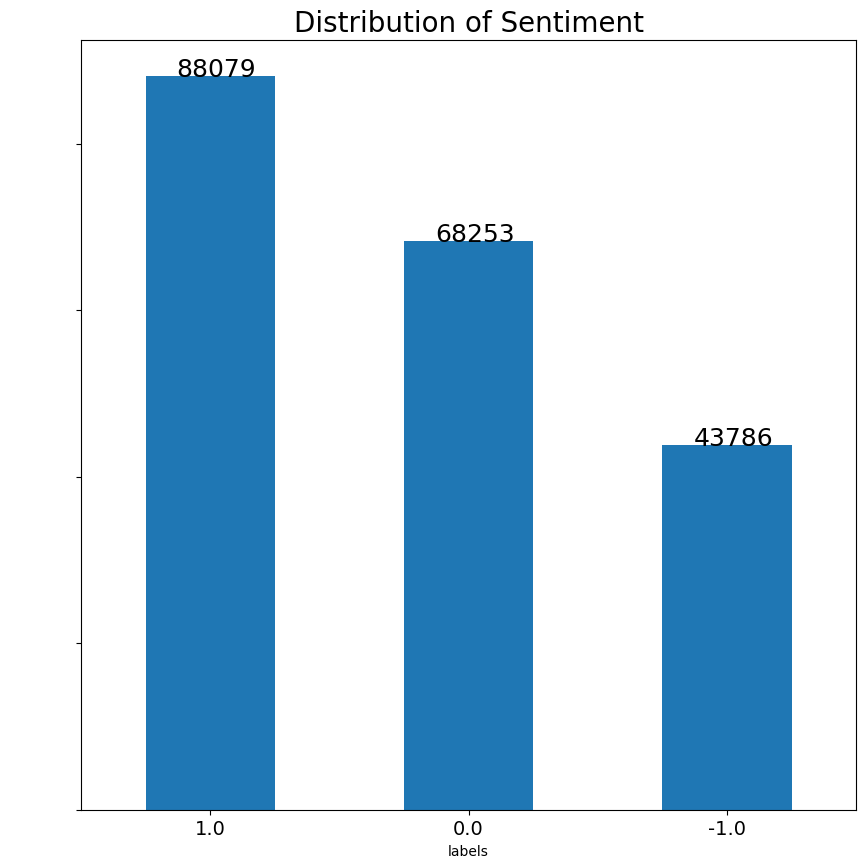

In [42]:
#Graph of Stopwords
fig , ax = plt.subplots(figsize = (10,10))
ax = data['labels'].value_counts().plot(kind = 'bar')

plt.xticks(rotation = 0, size = 14)
plt.yticks(size = 14, color = 'white')
plt.title('Distribution of Sentiment', size = 20)

ax.annotate(text = data['labels'].value_counts().values[0], xy = (-0.13,88079), size = 18)
ax.annotate(text = data['labels'].value_counts().values[1], xy = (0.87,68253), size = 18)
ax.annotate(text = data['labels'].value_counts().values[2], xy = (1.87,43786), size = 18)

plt.show()

# Train & Test Split

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200118 entries, 0 to 200228
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   labels           200118 non-null  float64
 1   messages1        200118 non-null  object 
 2   sentiment_score  200118 non-null  float64
 3   label            200118 non-null  object 
 4   length           200118 non-null  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 9.2+ MB


In [45]:
#Finding X and y
X = data['messages1']
y = data['labels']


In [46]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [47]:
##Vectorize text data
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize logistic regression model
log_reg_model = LogisticRegression()

# Train the logistic regression model on the training data
log_reg_model.fit(X_train_tfidf, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [49]:
# Predict on the testing data
y_pred_log_reg = log_reg_model.predict(X_test_tfidf)

In [50]:
# Calculate accuracy
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print("Logistic Regression Accuracy:", accuracy_log_reg)

Logistic Regression Accuracy: 0.9250949430341795


In [51]:

import pickle
pickle.dump(log_reg_model,open('Logistic.pkl','wb'))

In [52]:
# Generate confusion matrix
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
print("Logistic Regression Confusion Matrix:")
print(conf_matrix_log_reg)


Logistic Regression Confusion Matrix:
[[3538  315  435]
 [  54 6695   98]
 [ 309  288 8280]]


In [53]:
pip install scikit-plot

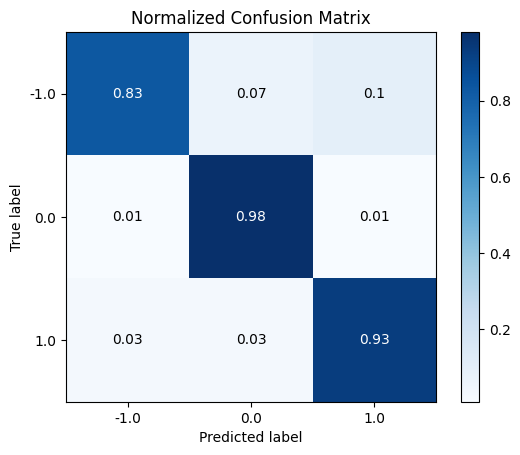

In [54]:
import scikitplot as skplt
import matplotlib.pyplot as plt
# Plot normalized confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred_log_reg, normalize=True)
plt.title("Normalized Confusion Matrix")
plt.show()

In [55]:
# Generate classification report
report_log_reg = classification_report(y_test, y_pred_log_reg)
print("Logistic Regression Classification Report:")
print(report_log_reg)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

        -1.0       0.91      0.83      0.86      4288
         0.0       0.92      0.98      0.95      6847
         1.0       0.94      0.93      0.94      8877

    accuracy                           0.93     20012
   macro avg       0.92      0.91      0.92     20012
weighted avg       0.92      0.93      0.92     20012



# DecisionTreeClassifier

In [56]:
from sklearn.tree import DecisionTreeClassifier

# Initialize Decision Tree Classifier model
dt_model = DecisionTreeClassifier(max_depth=3, min_samples_split=2)


# Train the Decision Tree Classifier model on the training data
dt_model.fit(X_train_tfidf, y_train)

# Predict on the testing data
y_pred_dt = dt_model.predict(X_test_tfidf)


In [57]:
# Calculate accuracy
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Classifier Accuracy:", accuracy_dt)

# Generate confusion matrix
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print("Decision Tree Classifier Confusion Matrix:")
print(conf_matrix_dt)

Decision Tree Classifier Accuracy: 0.49105536677993206
Decision Tree Classifier Confusion Matrix:
[[  19 2235 2034]
 [   1 4982 1864]
 [  14 4037 4826]]


In [58]:
# Generate classification report
report_dt = classification_report(y_test, y_pred_dt)
print("Decision Tree Classifier Classification Report:")
print(report_dt)

Decision Tree Classifier Classification Report:
              precision    recall  f1-score   support

        -1.0       0.56      0.00      0.01      4288
         0.0       0.44      0.73      0.55      6847
         1.0       0.55      0.54      0.55      8877

    accuracy                           0.49     20012
   macro avg       0.52      0.43      0.37     20012
weighted avg       0.52      0.49      0.43     20012



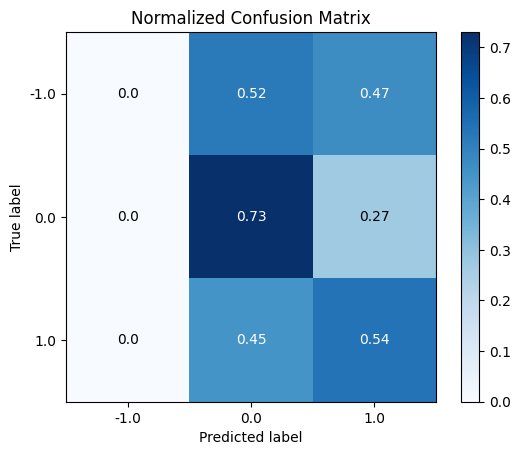

In [59]:
import scikitplot as skplt
import matplotlib.pyplot as plt
# Plot normalized confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred_dt, normalize=True)
plt.title("Normalized Confusion Matrix")
plt.show()

# RandomForestClassifier

In [60]:
from sklearn.ensemble import RandomForestClassifier

# Initialize RandomForest Classifier model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10)

# Train the RandomForest Classifier model on the training data
rf_model.fit(X_train_tfidf, y_train)

RandomForestClassifier(max_depth=10)

In [61]:
# Predict on the testing data
y_pred_rf = rf_model.predict(X_test_tfidf)


In [62]:
# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("RandomForest Classifier Accuracy:", accuracy_rf)

# Generate confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("RandomForest Classifier Confusion Matrix:")
print(conf_matrix_rf)

# Generate classification report
report_rf = classification_report(y_test, y_pred_rf)
print("RandomForest Classifier Classification Report:")
print(report_rf)

RandomForest Classifier Accuracy: 0.4435838496901859
RandomForest Classifier Confusion Matrix:
[[   0    0 4288]
 [   0    0 6847]
 [   0    0 8877]]
RandomForest Classifier Classification Report:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00      4288
         0.0       0.00      0.00      0.00      6847
         1.0       0.44      1.00      0.61      8877

    accuracy                           0.44     20012
   macro avg       0.15      0.33      0.20     20012
weighted avg       0.20      0.44      0.27     20012



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



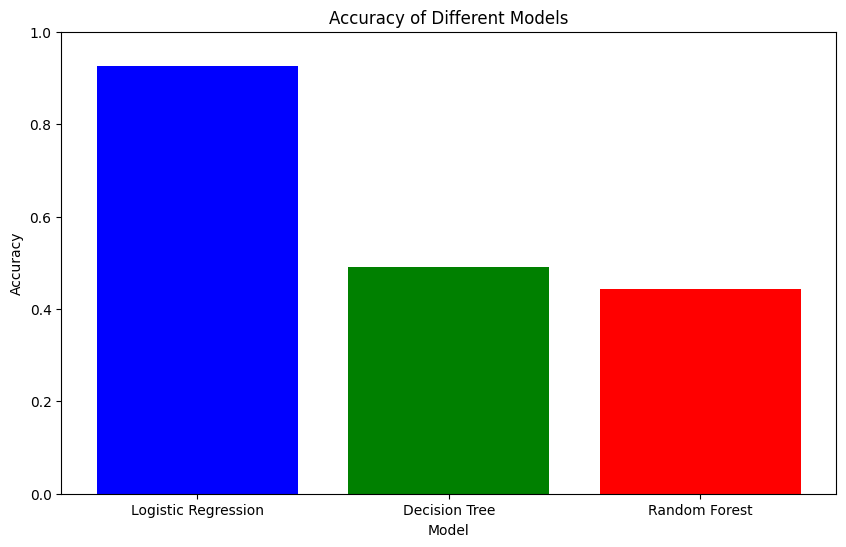

In [64]:
import matplotlib.pyplot as plt

# Lists to store model names and accuracies
model_names = ["Logistic Regression", "Decision Tree", "Random Forest"]
accuracies = [0.9250949430341795, 0.49105536677993206,0.4435838496901859]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.show()
